<a href="https://colab.research.google.com/github/chad-fisher/CRWA-Regional-Tree-Planting-and-Protection-Plan/blob/main/CodeNotebookInvasivesOnly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

In [ ]:
#Need this because on a different computer :(
!pip install matplotlib_scalebar
!pip install contextily
!pip install wget
!pip install pyinaturalist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=d3b636e464f99938cd5987f6cd70675f788a328d13c7ef86e43185bc9788f521
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.5 MB/s eta 0:00:00


In [1]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as cx
import ee
import geemap
import geemap.foliumap as geemapf
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import wget
import zipfile
import datetime
import pyinaturalist
from scipy import ndimage
import urllib
import altair as alt

In [2]:
#Authenticate to Earth Engine
ee.Authenticate()

<IPython.core.display.HTML object>

True

In [3]:
#Initialize earth engine project
ee.Initialize(project='ee-cefisher20')

<IPython.core.display.HTML object>

# Extracting watershed boundaries

In [4]:
#HUC codes from https://apps.nationalmap.gov/viewer/
Charles=ee.FeatureCollection("USGS/WBD/2017/HUC10").filter("huc10 == '0109000107' or huc10 == '0109000106'")
Charles_lower=ee.FeatureCollection("USGS/WBD/2017/HUC10").filter("huc10 == '0109000107'")
Charles_upper=ee.FeatureCollection("USGS/WBD/2017/HUC10").filter("huc10 == '0109000106'")
Charles.first().geometry().projection()

<IPython.core.display.HTML object>

<ee.projection.Projection object at 0x7a0f41bfe890>

In [22]:
#Convert earth engine feature collections to geopandas data frames
Charles_gdf = ee.data.computeFeatures({
    'expression': Charles,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
Charles_gdf.crs = 'EPSG:4326'

Charles_lower_gdf = ee.data.computeFeatures({
    'expression': Charles_lower,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
Charles_lower_gdf.crs = 'EPSG:4326'

Charles_upper_gdf = ee.data.computeFeatures({
    'expression': Charles_upper,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
Charles_upper_gdf.crs = 'EPSG:4326'

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

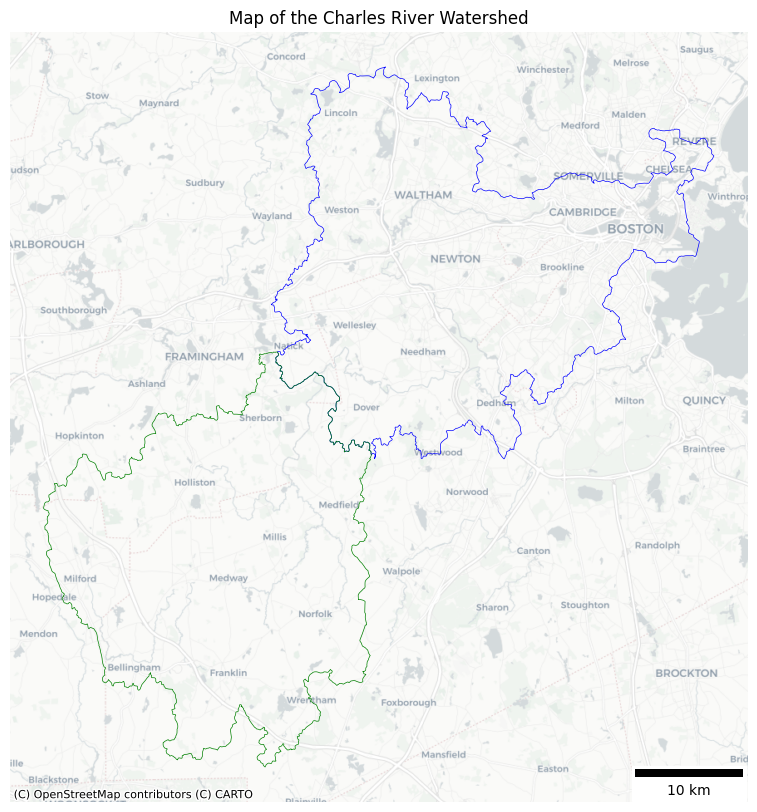

In [ ]:
ax = Charles_lower_gdf.to_crs(epsg=3857).boundary.plot(figsize=(10,10), color='blue',linewidth=0.5)
Charles_upper_gdf.to_crs(epsg=3857).boundary.plot(ax=ax,figsize=(10,10), color='green',linewidth=0.5)
plt.title("Map of the Charles River Watershed")
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.add_artist(ScaleBar(1,location='lower right'))
plt.savefig("Charles Watershed Maps.png")

In [5]:
#Create function to clip image to be used for clipping image collections
def Charclip(image):
    return image.clip(Charles)

<IPython.core.display.HTML object>

# Land Cover Maps

In [6]:
#Forest Areas
NLCD2019lc=ee.Image('USGS/NLCD_RELEASES/2019_REL/NLCD/2019').clip(Charles).select('landcover')
map_1 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
map_1.add_layer(NLCD2019lc.updateMask(NLCD2019lc.eq(41)),name='Deciduous Forest',color='light green')
map_1.add_layer(NLCD2019lc.updateMask(NLCD2019lc.eq(42)),name='Evergreen Forest',color='dark green')
map_1.add_layer(NLCD2019lc.updateMask(NLCD2019lc.eq(43)),name='Mixed Forest',color='green')
map_1

#NLCD change maps for forest types, check out different times
#Add boundary to map

<IPython.core.display.HTML object>

<geemap.foliumap.Map object at 0x7a0f41bfe680>

In [7]:
#Impervious Cover
NLCD2019=ee.Image('USGS/NLCD_RELEASES/2019_REL/NLCD/2019').clip(Charles).select('impervious')
map_2 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
image_viz_params = {
    'bands': ['impervious'],
    'min': 0,
    'max': 100,
    'palette': 'plasma'
}
map_2.add_layer(NLCD2019, image_viz_params)
map_2

#NLCD data from previous years to see changes

<IPython.core.display.HTML object>

<geemap.foliumap.Map object at 0x7a0f41bff040>

# Invasive Species Data Collection

In [8]:
#Extract Sentinel 2 bands and indices of interest
def extractBandsIndices(image):
    return image.select(['B2','B3','B4','B5_10m','B6_10m','B7_10m','B8','B8A_10m','B11_10m','B12_10m',
                         'NDVI','NBR','SAVI','RENDVI','EVI'])

<IPython.core.display.HTML object>

In [9]:
#Resample Sentinel 2 bands to 10 m
def resample10m(image):
    proj_10m=image.select('B4').projection()
    B5_res=image.select('B5').resample('bicubic').reproject(proj_10m).rename('B5_10m')
    B6_res=image.select('B6').resample('bicubic').reproject(proj_10m).rename('B6_10m')
    B7_res=image.select('B7').resample('bicubic').reproject(proj_10m).rename('B7_10m')
    B8A_res=image.select('B8A').resample('bicubic').reproject(proj_10m).rename('B8A_10m')
    B11_res=image.select('B11').resample('bicubic').reproject(proj_10m).rename('B11_10m')
    B12_res=image.select('B12').resample('bicubic').reproject(proj_10m).rename('B12_10m')
    return image.addBands([B5_res,B6_res,B7_res,B8A_res,B11_res,B12_res])

<IPython.core.display.HTML object>

In [10]:
#Add 5 vegetation indices of interest
def addIndices(image):
    NDVI = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    NBR = image.normalizedDifference(['B12_10m','B8']).rename('NBR')
    SAVI = image.expression(
        '1.5 * ((NIR - RED)) / (NIR + RED + 0.5)', {
            'NIR' : image.select('B8'),
            'RED' : image.select('B4'),
        }).rename('SAVI')
    RENDVI = image.normalizedDifference(['B6_10m','B5_10m']).rename('RENDVI')
    EVI = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR' : image.select('B8'),
            'RED' : image.select('B4'),
            'BLUE': image.select('B2')}).rename('EVI')
    return image.addBands([NDVI,NBR,SAVI,RENDVI,EVI])

<IPython.core.display.HTML object>

In [11]:
#Cloud mask function
def mask_s2_clouds(image):
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = (
        qa.bitwiseAnd(cloud_bit_mask)
        .eq(0)
        .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    )
    return image.updateMask(mask).divide(10000)

<IPython.core.display.HTML object>

In [12]:
#Land cover mask function
def mask_forests(image):
    mask=(NLCD2019lc.eq(41).Or(NLCD2019lc.eq(42).Or(NLCD2019lc.eq(43))))
    return image.updateMask(mask)

<IPython.core.display.HTML object>

In [73]:
#Pre-processing sentinel-2 data
S2_All=ee.ImageCollection(("COPERNICUS/S2_SR_HARMONIZED")).filterDate('2019-01-01','2020-01-01').filterBounds(Charles.geometry()).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)).map(mask_s2_clouds).map(mask_forests).map(Charclip).map(resample10m).map(addIndices).map(extractBandsIndices)

<IPython.core.display.HTML object>

In [62]:
S2_All.first().geometry()

<IPython.core.display.HTML object>

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Image.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Collection.first",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.map",
                "arguments": {
                  "baseAlgorithm": {
                    "functionDefinitionValue": {
                      "argumentNames": [
                        "_MAPPING_VAR_0_0"
                      ],
                      "body": {
                        "functionInvocationValue": {
                          "functionName": "Image.select",
                          "arguments": {
                            "bandSelectors": {
                              "constantValue": [
                                "B2",
                                "B3",
                                "B4",
                                "B5_10m",
                                "B6_10m",
                                "B7_10m",
                                "B8",
                                "B8A_10m",
                                "B11_10m",
                                "B12_10m",
                                "NDVI",
                                "NBR",
                                "SAVI",
                                "RENDVI",
                                "EVI"
                              ]
                            },
                            "input": {
                              "argumentReference": "_MAPPING_VAR_0_0"
                            }
                          }
                        }
                      }
                    }
                  },
                  "collection": {
                    "functionInvocationValue": {
                      "functionName": "Collection.map",
                      "arguments": {
                        "baseAlgorithm": {
                          "functionDefinitionValue": {
                            "argumentNames": [
                              "_MAPPING_VAR_0_0"
                            ],
                            "body": {
                              "functionInvocationValue": {
                                "functionName": "Image.addBands",
                                "arguments": {
                                  "dstImg": {
                                    "argumentReference": "_MAPPING_VAR_0_0"
                                  },
                                  "srcImg": {
                                    "functionInvocationValue": {
                                      "functionName": "Image.addBands",
                                      "arguments": {
                                        "dstImg": {
                                          "functionInvocationValue": {
                                            "functionName": "Image.addBands",
                                            "arguments": {
                                              "dstImg": {
                                                "functionInvocationValue": {
                                                  "functionName": "Image.addBands",
                                                  "arguments": {
                                                    "dstImg": {
                                                      "functionInvocationValue": {
                                                        "functionName": "Image.addBands",
                                                        "arguments": {
                                                          "dstImg": {
                                                            "functionInvocationValue": {
                                                              "functionName": "Image.rename",
                                                              "arguments": {
                           

In [74]:
S2_All_list=S2_All.toList(S2_All.size())
ee.Image(S2_All_list.get(0)).getInfo()

<IPython.core.display.HTML object>

<ee.image.Image object at 0x7a0f3af42200>

In [77]:
S2_All.first().getInfo()

<IPython.core.display.HTML object>


{
    'type': 'Image',
    'bands': [
        {
            'id': 'B2',
            'data_type': {
                'type': 'PixelType',
                'precision': 'float',
                'min': 0,
                'max': 6.553500175476074
            },
            'dimensions': [10980, 10980],
            'crs': 'EPSG:32618',
            'crs_transform': [10, 0, 699960, 0, -10, 4700040]
        },
        {
            'id': 'B3',
            'data_type': {
                'type': 'PixelType',
                'precision': 'float',
                'min': 0,
                'max': 6.553500175476074
            },
            'dimensions': [10980, 10980],
            'crs': 'EPSG:32618',
            'crs_transform': [10, 0, 699960, 0, -10, 4700040]
        },
        {
            'id': 'B4',
            'data_type': {
                'type': 'PixelType',
                'precision': 'float',
                'min': 0,
                'max': 6.553500175476074
            },
           

In [75]:
#Map of first image in collection
map_3 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
map_3.add_layer(ee.Image(S2_All_list.get(0)), {'bands':['B4','B3','B2'],'min':0,'max':0.2})
map_3

<IPython.core.display.HTML object>

<geemap.foliumap.Map object at 0x7a0f3af33880>

In [ ]:
videoArgs = {
  'dimensions': 290,
  'region': Charles.geometry(),
  'framesPerSecond': 1,
  'crs': 'EPSG:3857',
  'min': 0,
  'max': .2,
  'format':'gif'
}

urllib.request.urlretrieve(S2_All.getVideoThumbURL(videoArgs),'S2Data2019_2020.gif')

In [78]:
RENDVI=S2_All.select('RENDVI')

<IPython.core.display.HTML object>

In [79]:
RENDVI_list=RENDVI.toList(RENDVI.size())

<IPython.core.display.HTML object>

In [ ]:
map_4 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
map_4.add_layer(ee.Image(NDVI_list.get(0)))
map_4.add_layer(test_point)
map_4

<IPython.core.display.HTML object>

<geemap.foliumap.Map object at 0x7da87d345120>

In [82]:
videoArgs = {
  'dimensions': 290,
  'region': Charles.geometry(),
  'framesPerSecond': 1,
  'crs': 'EPSG:3857',
  'min':0,
  'max':1,
  'format':'gif'
}
RENDVI.getVideoThumbURL(videoArgs)

<IPython.core.display.HTML object>

'https://earthengine.googleapis.com/v1/projects/ee-cefisher20/videoThumbnails/dae6b3a6529fbdcc80ffb3c18e918ff6-88e0b00d2a013342edb19777cf20c27c:getPixels'

In [17]:
#List of invasive species of interest
# Japanese knotweed, Asian bittersweet, glossy buckthorn, euonymous, multiflora rose, cork tree, kudzu, porcelain berry
# https://www.massaudubon.org/nature-wildlife/invasive-plants-in-massachusetts
def get_obs(years,taxon_id):
  response=pyinaturalist.v1.observations.get_observations(year=years,taxon_id=taxon_id,geo=True,page='all',place_id=2)
  my_observations = pyinaturalist.Observation.from_json_list(response)
  df = pd.DataFrame(
      [
          {
              'latitude': o.location[0],
              'longitude': o.location[1],
              'date': o.observed_on.isoformat()
          }
          for o in my_observations
          if o.location
      ]
  )
  gdf = gpd.GeoDataFrame(
      df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
  )
  return gdf

<IPython.core.display.HTML object>

In [ ]:
# https://nbviewer.org/gist/perrygeo/c426355e40037c452434
def density_heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.gaussian_filter(logheatmap, smoothing, mode='nearest')

    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

<IPython.core.display.HTML object>

In [18]:

years=[2020]
knotweed=914922
bittersweet=64540
buckthorn=55972
euonymus=117433
multiflora=78882
corktree=166636
porcelain=204237
kudzu=62671
barberry=58727

knot_gdf=get_obs(years,knotweed)
bitt_gdf=get_obs(years,bittersweet)
buck_gdf=get_obs(years,buckthorn)
euon_gdf=get_obs(years,euonymus)
mult_gdf=get_obs(years,multiflora)
cork_gdf=get_obs(years,corktree)
porc_gdf=get_obs(years,porcelain)
kudz_gdf=get_obs(years,kudzu)
barb_gdf=get_obs(years,barberry)

<IPython.core.display.HTML object>

In [19]:
d={
  'Knotweed':knot_gdf,
  'Bittersweet':bitt_gdf,
  'Buckthorn':buck_gdf,
  'Euonymus':euon_gdf,
  'Multiflora':mult_gdf,
  'Corktree':cork_gdf,
  'Porcelain Berry':porc_gdf,
  'Kudzu':kudz_gdf,
  'Barberry':barb_gdf
}
for name, value in d.items():
  ax = Charles_lower_gdf.to_crs(epsg=3857).boundary.plot(figsize=(10,10), color='blue',linewidth=0.5)
  Charles_upper_gdf.to_crs(epsg=3857).boundary.plot(ax=ax,figsize=(10,10), color='green',linewidth=0.5)
  value.clip(Charles_gdf).to_crs(epsg=3857).plot(ax=ax)
  plt.title(name+" (2020 - 2024)")
  cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
  ax.set_axis_off()
  ax.add_artist(ScaleBar(1,location='lower right'))
  plt.savefig(name+'.png')

<IPython.core.display.HTML object>

NameError: name 'Charles_lower_gdf' is not defined

In [ ]:
def extractPixel(image):
  return image.sample(test_point)

<IPython.core.display.HTML object>

In [61]:
coords=[barb_gdf.clip(Charles_gdf)['longitude'][96],barb_gdf.clip(Charles_gdf)['latitude'][96]]

<IPython.core.display.HTML object>


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [58]:
test_point=ee.Geometry.Point(coords)

<IPython.core.display.HTML object>

In [72]:
pd.DataFrame(data=S2_All.getRegion(test_point,10).getInfo()[1:],columns=S2_All.getRegion(test_point,10).getInfo()[0])
pd.DataFrame['time']=pd.DataFrame

<IPython.core.display.HTML object>

,id,longitude,latitude,time,B2,B3,B4,B5_10m,B6_10m,B7_10m,B8,B8A_10m,B11_10m,B12_10m,NDVI,NBR,SAVI,RENDVI,EVI
0,20190103T154641_20190103T154635_T19TCG,-71.173924,42.27045,None,0.0506,0.0702,0.0920,0.115025,0.144094,0.153932,0.2080,0.184741,0.176585,0.124712,0.386667,-0.250329,0.217500,0.112183,0.210069
1,20190103T154641_20190103T155109_T19TCG,-71.173924,42.27045,None,0.0506,0.0709,0.0931,0.114501,0.143119,0.152586,0.2048,0.182464,0.175451,0.123901,0.374958,-0.246118,0.209989,0.111086,0.201785
2,20190113T154611_20190113T155046_T19TCG,-71.173924,42.27045,None,0.0751,0.0964,0.1242,0.141039,0.161437,0.180749,0.2160,0.198642,0.216547,0.170928,0.269841,-0.116487,0.163890,0.067436,0.164169
3,20190115T153609_20190115T153706_T19TCG,-71.173924,42.27045,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20190125T153559_20190125T153556_T19TCG,-71.173924,42.27045,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,20191126T153601_20191126T154037_T19TCG,-71.173924,42.27045,None,0.0600,0.0890,0.1316,0.169186,0.204305,0.228094,0.3098,0.267382,0.244137,0.183587,0.403715,-0.255810,0.283939,0.094030,0.270098
59,20191129T154611_20191129T155035_T19TCG,-71.173924,42.27045,None,0.0551,0.0797,0.1070,0.139959,0.170716,0.191005,0.2504,0.226928,0.214659,0.154752,0.401231,-0.236078,0.250875,0.099001,0.242369
60,20191219T154641_20191219T154831_T19TCG,-71.173924,42.27045,None,0.1826,0.2040,0.2240,0.247971,0.272562,0.262050,0.3406,0.300325,0.158847,0.135643,0.206518,-0.430361,0.164287,0.047241,0.221656
61,20191219T154641_20191219T155110_T19TCG,-71.173924,42.27045,None,0.1852,0.2056,0.2238,0.246480,0.270024,0.260035,0.3356,0.297000,0.158210,0.135416,0.199857,-0.425005,0.158297,0.045585,0.216767


In [ ]:
# Why do I get an error for some of the gifs I'm trying to generate but not others?
# How to extract pixel values from image collection so I can make time series graphs?
# How to get data stacked from my image collection into a matrix so I can run machine learning?



#Upsample if I want to make GIF